# Causal Discovery in the Presence of Latent Confounders

We learn a causal graph from observed data, in the possible presence of latent confounders and selection bias.
Here we assume that the true underlying causal diagram is a directed acyclic graph (DAG), $\mathcal{D}(\mathbf{O}, \mathbf{L}, \mathbf{S})$, where $\mathbf{O}$, $\mathbf{L}$, and $\mathbf{S}$ are observed, latent confounders, and selection variables, respectively.
For this DAG, we assume causal Markov and faithfulness assumptions.
In this setting, a maximal ancestral graph (MAG) defined over $\mathbf{O}$ is often used to represent the DAG.

The ICD algorithm learns a partial ancestral graph (PAG),
which is an equivalence class of the true causal graph (an equivalence class of MAGs).

For demonstrating the usage of ICD we follow these steps:
1. Setup experiment (create training data)
2. Define a conditional independence function to be used by the ICD algorithm
3. Learn a causal graph using the ICD algorithm
4. Calculate the accuracy of the learned graph
5. Compare the performance of the ICD algorithm to the FCI algorithm

Initially, the required classes and methods are imported.

In [1]:
import sys
sys.path.append('..')

import random
import numpy as np
from causal_discovery_algs import LearnStructICD, LearnStructFCI
from causal_discovery_utils.cond_indep_tests import CondIndepParCorr  # import a CI test that estimates partial correlation
from experiment_utils.synthetic_graphs import create_random_dag_with_latents, sample_data_from_dag
from causal_discovery_utils.performance_measures import calc_structural_accuracy_pag, find_true_pag
from matplotlib import pyplot as plt

## Experiment Setup

Initially, we will create the data that will be used in this experiment. Here, we will randomly create a small causal DAG
and create a probabilistic model by assigning linear relations and normally distributed noise.

In [2]:
rand_seed = 42  # arbitrary seed (ASCII code of the Asterisk symbol)
random.seed(rand_seed)
np.random.seed(rand_seed)

Setup simulation parameters

In [3]:
num_nodes = 15
num_records = 1000
connectivity_coeff = 2.0
min_lin_coeff = 0.5  # minimal 'strength' of an edge
max_lin_coeff = 2.0  # maximal 'strength' of an edge
alpha = 0.01

Generate a random DAG, $\mathcal{D}(\mathbf{O},\mathbf{L},\mathbf{S=\emptyset})$, to serve as the
true underlying causal diagram.

In [4]:
dag, observed_set, latents_set = create_random_dag_with_latents(
    num_nodes,
    connectivity_coeff
)

Find the PAG (equivalence class) corresponding to the true DAG

In [5]:
true_pag = find_true_pag(dag, observed_set)

Sample a dataset from the DAG by quantifying the edges and adding normally distributed noise

In [6]:
dataset = sample_data_from_dag(
    dag,
    num_records,
    min_edge_weight=min_lin_coeff, max_edge_weight=max_lin_coeff
)

## Define a Conditional Independence Test

Constraint-based algorithms, such as ICD and FCI, employ a statistical hypothesis test for estimating
if two variables are statistically independent, conditioned on a set of variables.
Several such conditional independence (CI) are implemented.
Here, we use a CI test based on partial correlation, which is suitable for our linear-Gaussian case.
A class instance is created.

In [7]:
par_corr_icd = CondIndepParCorr(
    dataset=dataset,
    threshold=alpha,
    count_tests=True,
    use_cache=True
)

We enabled *count_test* so the number of unique CI tests is recorded per conditioning set size.
It is not necessary to for the normal operation of the CI test and the ICD algorithm
Also, We enabled caching to make sure that the statistic for the same CI test is not calculated more than once.
Nevertheless, ICD does not perform the same CI test more than once.

## Learn a PAG using the ICD algorithm

First an instance of the ICD class is created. The CI-test to be used during learning is provided here.
Then, the method *learn_structure* is called for learning the graph.
At this stage, the learned graph is stored within the class instance and
the number of CI tests that were performed is stored in the CI test class.

In [8]:
icd = LearnStructICD(observed_set, par_corr_icd)  # instantiate an ICD learner
icd.learn_structure()  # learn the PAG
learned_pag_icd = icd.graph

## Calculate the Accuracy of the Learned Graph

Here, we calculate the precision and recall of the skeleton (ignoring the edge-marks),
and the accuracy of the orientation.

In [9]:
icd_result = calc_structural_accuracy_pag(
    pag_tested=learned_pag_icd,
    pag_correct=true_pag
)

## Compare the Performance the ICD Algorithm to the FCI Algorithm

First, we learn a PAG using the FCI algorithm. We repeat the same steps used for learning with ICD.

In [10]:
# Learn the PAG
par_corr_fci = CondIndepParCorr(dataset=dataset, threshold=alpha, count_tests=True, use_cache=True)  # CI test
fci = LearnStructFCI(observed_set, par_corr_fci)  # instantiate an ICD learner
fci.learn_structure()  # learn the PAG
learned_pag_fci = fci.graph

# Calculate structural errors: FCI algorithm
fci_result = calc_structural_accuracy_pag(pag_tested=learned_pag_fci, pag_correct=true_pag)

For easy plotting, we define the following function.

In [11]:
def print_structural_accuracy(structural_accuracy: dict):
    print('Edge precision: {:.2f}'.format(structural_accuracy['edge_precision']))
    print('Edge recall: {:.2f}'.format(structural_accuracy['edge_recall']))
    print('F1 Score: {:.2f}'.format(structural_accuracy['edge_F1']))
    print('Orientation accuracy: {:.2f}'.format(structural_accuracy['orientation_correctness']))

Finally, we print the accuracy of the learned PAG, and plot the number of CI tests per conditioning set size.


ICD performance
---------------
Edge precision: 1.00
Edge recall: 0.73
F1 Score: 0.84
Orientation accuracy: 0.52
Total number of CI tests:  246

FCI performance
---------------
Edge precision: 1.00
Edge recall: 0.50
F1 Score: 0.67
Orientation accuracy: 0.36
Total number of CI tests:  662


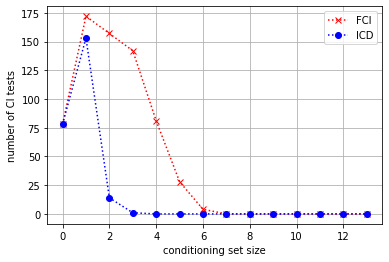

In [12]:
print('\nICD performance')
print('---------------')
print_structural_accuracy(icd_result)
print('Total number of CI tests: ', sum(par_corr_icd.test_counter))

print('\nFCI performance')
print('---------------')
print_structural_accuracy(fci_result)
print('Total number of CI tests: ', sum(par_corr_fci.test_counter))

plt.figure()
x_range = range(len(par_corr_icd.test_counter))
plt.plot(x_range, par_corr_fci.test_counter, 'xr:',
         x_range, par_corr_icd.test_counter, 'ob:')
plt.legend(('FCI', 'ICD'))
plt.xlabel('conditioning set size')
plt.ylabel('number of CI tests')
plt.grid(True)
plt.show()